Import required libraries

In [36]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

Load Dataset

In [37]:
data = pd.read_csv('complaints.csv', low_memory=False)
data.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"SANTANDER HOLDINGS USA, INC.",FL,33972,NaN,NaN,Web,2023-08-25,Closed with explanation,Yes,NaN,7512160
1,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,WELLS FARGO & COMPANY,CA,92394,NaN,NaN,Web,2023-08-25,In progress,Yes,NaN,7466203
2,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,WA,98507,NaN,NaN,Web,2023-08-23,In progress,Yes,NaN,7442793


Data Preprocessing

In [38]:
# How many unique financial products (the second column) are we talking about here
data['Product'].nunique()

21

We need only two columns from the dataset: text and label. We will drop the other columns.
Consumer complaints narrative is the text column and Product is the label column.

In [39]:
df=data[['Consumer complaint narrative','Product']]

# Remove missing values
df=df[pd.notnull(df['Consumer complaint narrative'])]
df.shape

(1464248, 2)

only add the product named as Credit reporting, credit repair services, or other personal consumer reports, Debt collection, Mortgage and Consumer Loan

In [40]:
df=df[df['Product'].isin(['Credit reporting, credit repair services, or other personal consumer reports','Debt collection','Mortgage','Consumer Loan'])]
df.head(5)

,Consumer complaint narrative,Product
233,I do not have any knowledge of applying for a ...,"Credit reporting, credit repair services, or o..."
249,I noticed a drop in my credit score on Experia...,"Credit reporting, credit repair services, or o..."
251,In accordance with the Fair Credit Reporting a...,"Credit reporting, credit repair services, or o..."
258,I am writing to urgently request the removal o...,"Credit reporting, credit repair services, or o..."
269,XXXX XXXX XXXX XXXX XXXX XXXX Pa XXXX XXXX XXX...,"Credit reporting, credit repair services, or o..."


In [41]:
#remove product with less than 1 complaints
df=df.groupby('Product').filter(lambda x: len(x) > 1)
df['Product'].value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    767235
Debt collection                                                                 218147
Mortgage                                                                        108059
Consumer Loan                                                                     9461
Name: count, dtype: int64

Reset the index of the dataframe and shuffle the data.

In [42]:
#reset index
df=df.reset_index(drop=True)
df.head(5)


,Consumer complaint narrative,Product
0,I do not have any knowledge of applying for a ...,"Credit reporting, credit repair services, or o..."
1,I noticed a drop in my credit score on Experia...,"Credit reporting, credit repair services, or o..."
2,In accordance with the Fair Credit Reporting a...,"Credit reporting, credit repair services, or o..."
3,I am writing to urgently request the removal o...,"Credit reporting, credit repair services, or o..."
4,XXXX XXXX XXXX XXXX XXXX XXXX Pa XXXX XXXX XXX...,"Credit reporting, credit repair services, or o..."


Split the data into train and test sets (75% and 25% respectively)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
                                            df['Consumer complaint narrative'], df['Product'], 
                                            test_size=0.25, random_state=0, stratify=df['Product'])
print(f'Training utterances: {len(X_train)} of shape {X_train.shape}')
print(f'Validation utterances: {len(X_test)} of shape {X_test.shape}')

Training utterances: 827176 of shape (827176,)
Validation utterances: 275726 of shape (275726,)


In [44]:
#display number of complaints per product in training set

display(y_train.value_counts())

Product
Credit reporting, credit repair services, or other personal consumer reports    575426
Debt collection                                                                 163610
Mortgage                                                                         81044
Consumer Loan                                                                     7096
Name: count, dtype: int64

In [45]:
#display number of complaints per product in test set
display(y_test.value_counts())

Product
Credit reporting, credit repair services, or other personal consumer reports    191809
Debt collection                                                                  54537
Mortgage                                                                         27015
Consumer Loan                                                                     2365
Name: count, dtype: int64

Feature Engineering

Vectorize the text column using TF-IDF Vectorizer to form a matrix

In [46]:
# instantiate the vectorizer object
vectorizer = TfidfVectorizer(stop_words= 'english')
# convert the documents into a matrix
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)
X_train_vec, X_test_vec

(<827176x126245 sparse matrix of type '<class 'numpy.float64'>'
 	with 40187212 stored elements in Compressed Sparse Row format>,
 <275726x126245 sparse matrix of type '<class 'numpy.float64'>'
 	with 13385966 stored elements in Compressed Sparse Row format>)

use ch2 to select the top 100 features from the vectorized matrix

In [47]:
from sklearn.feature_selection import SelectKBest, chi2

n_features=100

ch2 = SelectKBest(chi2, k=n_features)
X_train_sp = ch2.fit_transform(X_train_vec, y_train)
X_test_sp  = ch2.transform(X_test_vec)

X_train_sp, X_test_sp

(<827176x100 sparse matrix of type '<class 'numpy.float64'>'
 	with 6291741 stored elements in Compressed Sparse Row format>,
 <275726x100 sparse matrix of type '<class 'numpy.float64'>'
 	with 2099159 stored elements in Compressed Sparse Row format>)

Converting the sparse matrix to a dense one to visualize it. 

In [48]:
cols = list(range(n_features))

X_train_dense = pd.DataFrame(data=X_train_sp.toarray(), columns=cols)
X_test_dense  = pd.DataFrame(data=X_test_sp.toarray(), columns=cols)
print(X_train_dense.shape, X_test_dense.shape)
X_train_dense

(827176, 100) (275726, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,0.000000,0.335166,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.144852,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.658337,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.126225
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.121841
4,0.000000,0.000000,0.000000,0.207852,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827171,0.264885,0.213057,0.116572,0.000000,0.0,0.0,0.0,0.114573,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.365736
827172,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.596845
827173,0.000000,0.000000,0.000000,0.143050,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.398325
827174,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.162155,...,0.0,0.0,0.0,0.163121,0.0,0.0,0.0,0.115397,0.0,0.144510


Now we have train and test data as vectors Let us also convert the target data appropriately

In [49]:
encoder = LabelEncoder()
y_train_num  = encoder.fit_transform(y_train)
y_test_num   = encoder.transform(y_test)
y_train_num.min(), y_train_num.max(), y_test_num.min(), y_test_num.max() # sanity check

(0, 3, 0, 3)

In [50]:
# What does the target look like, after encoding. Check out the first n datapoints
n=5
print('Text   Encoding')
print('-'*50)
for p,q in zip(y_train[:n].values,y_train_num):
    print(f'{q}      {p}')

Text   Encoding
--------------------------------------------------
1      Credit reporting, credit repair services, or other personal consumer reports
1      Credit reporting, credit repair services, or other personal consumer reports
2      Debt collection
2      Debt collection
1      Credit reporting, credit repair services, or other personal consumer reports


In [51]:
mapping = {l: i for i, l in enumerate(encoder.classes_)}
mapping

{'Consumer Loan': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 1,
 'Debt collection': 2,
 'Mortgage': 3}

Random Forest Classifier Model to predict the product from the complaint narrative text column. 

In [52]:
rf_model  = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1)
scores = cross_val_score(rf_model,
                         X_train_dense,
                         y_train_num,
                         cv=5,
                         n_jobs = -1,
                         scoring = 'accuracy')
scores.mean()

0.9177321392883249

Fit the model on the train data and predict the labels of the test data.

In [53]:
rf_model.fit(X_train_dense, y_train_num)
preds=rf_model.predict(X_test_dense)



Model Evaluation

In [54]:
#accuracy score
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_num, preds))


0.921360335985725


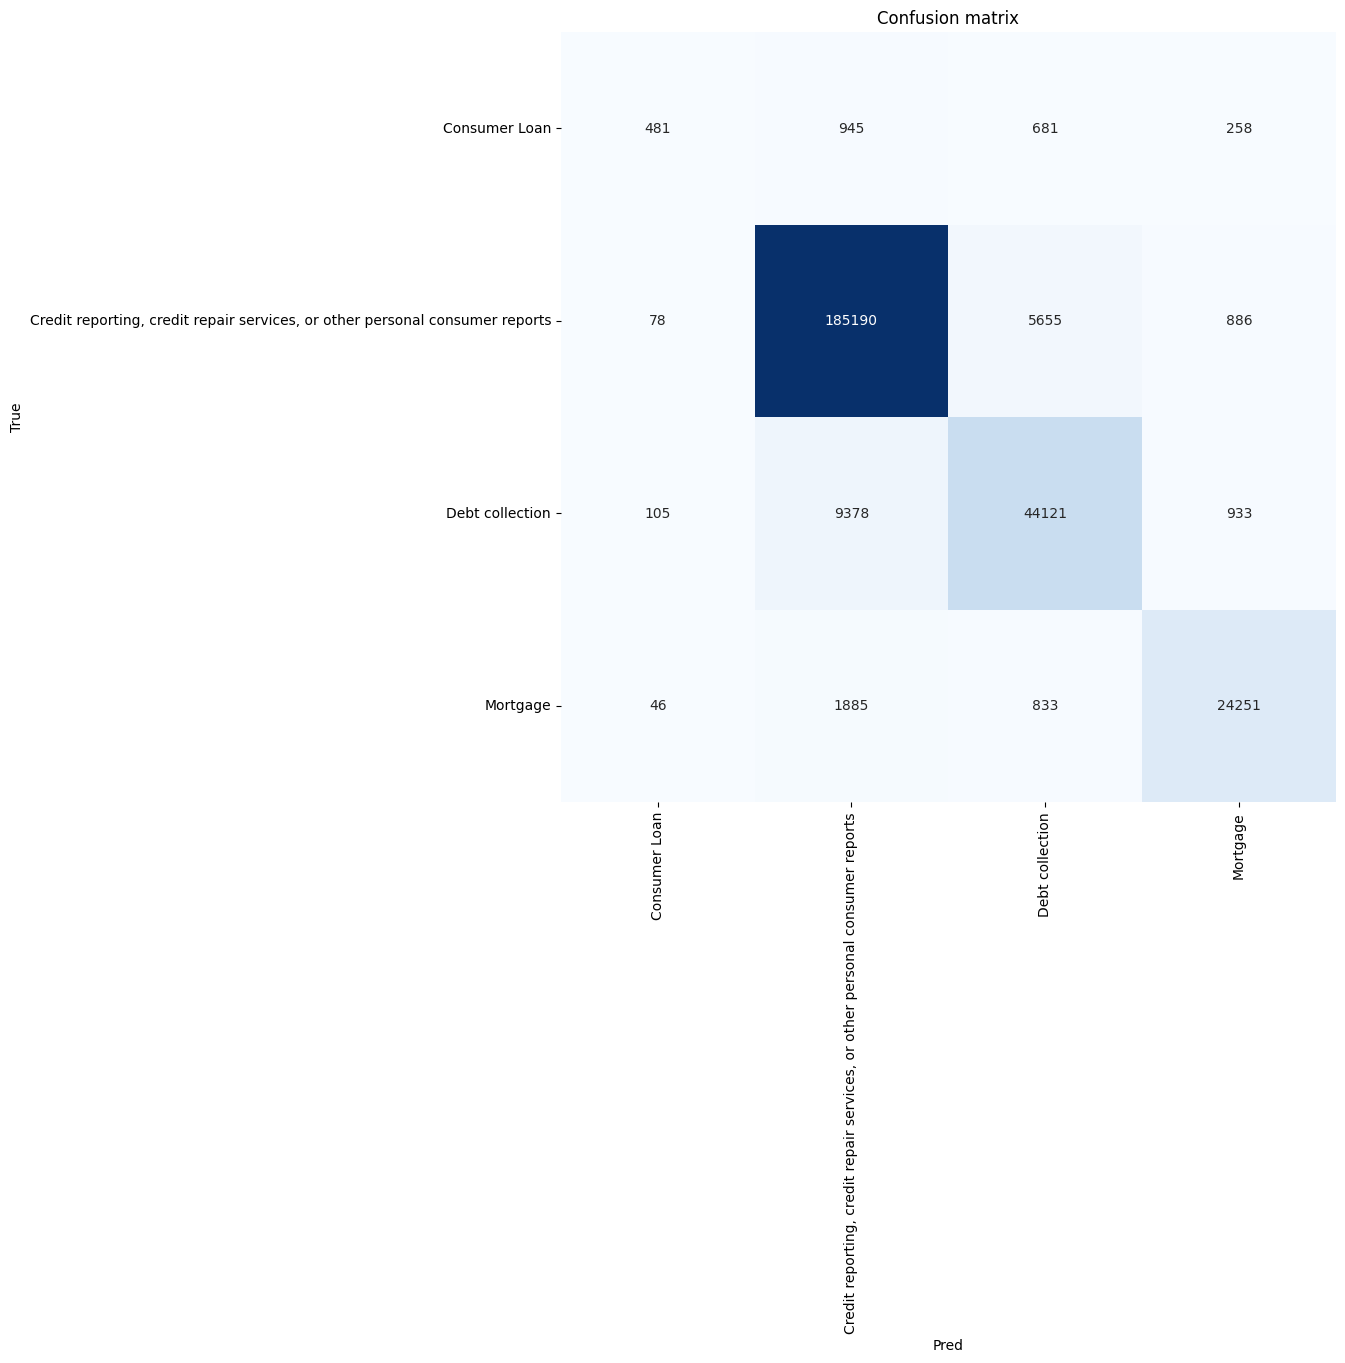

                                                                              precision    recall  f1-score   support

                                                               Consumer Loan       0.68      0.20      0.31      2365
Credit reporting, credit repair services, or other personal consumer reports       0.94      0.97      0.95    191809
                                                             Debt collection       0.86      0.81      0.83     54537
                                                                    Mortgage       0.92      0.90      0.91     27015

                                                                    accuracy                           0.92    275726
                                                                   macro avg       0.85      0.72      0.75    275726
                                                                weighted avg       0.92      0.92      0.92    275726



In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_num, preds)
cm

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=encoder.classes_, yticklabels=encoder.classes_, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

#classification report
from sklearn.metrics import classification_report

print(classification_report(y_test_num, preds, target_names=encoder.classes_))

Logistic Regression Model to predict the product from the complaint narrative text column.

In [56]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_model  = LogisticRegression(random_state=42, n_jobs = -1)
scores = cross_val_score(lr_model,
                            X_train_dense,
                            y_train_num,
                            cv=5,
                            n_jobs = -1,
                            scoring = 'accuracy')
scores.mean()


0.8765982076536636

Fit the model on the train data and predict the labels of the test data.

In [57]:
lr_model.fit(X_train_dense, y_train_num)
preds=lr_model.predict(X_test_dense)
print('Predictions ready')




Predictions ready


Model Evaluation

In [58]:
#accuracy score
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_num, preds))



0.8776357688429818


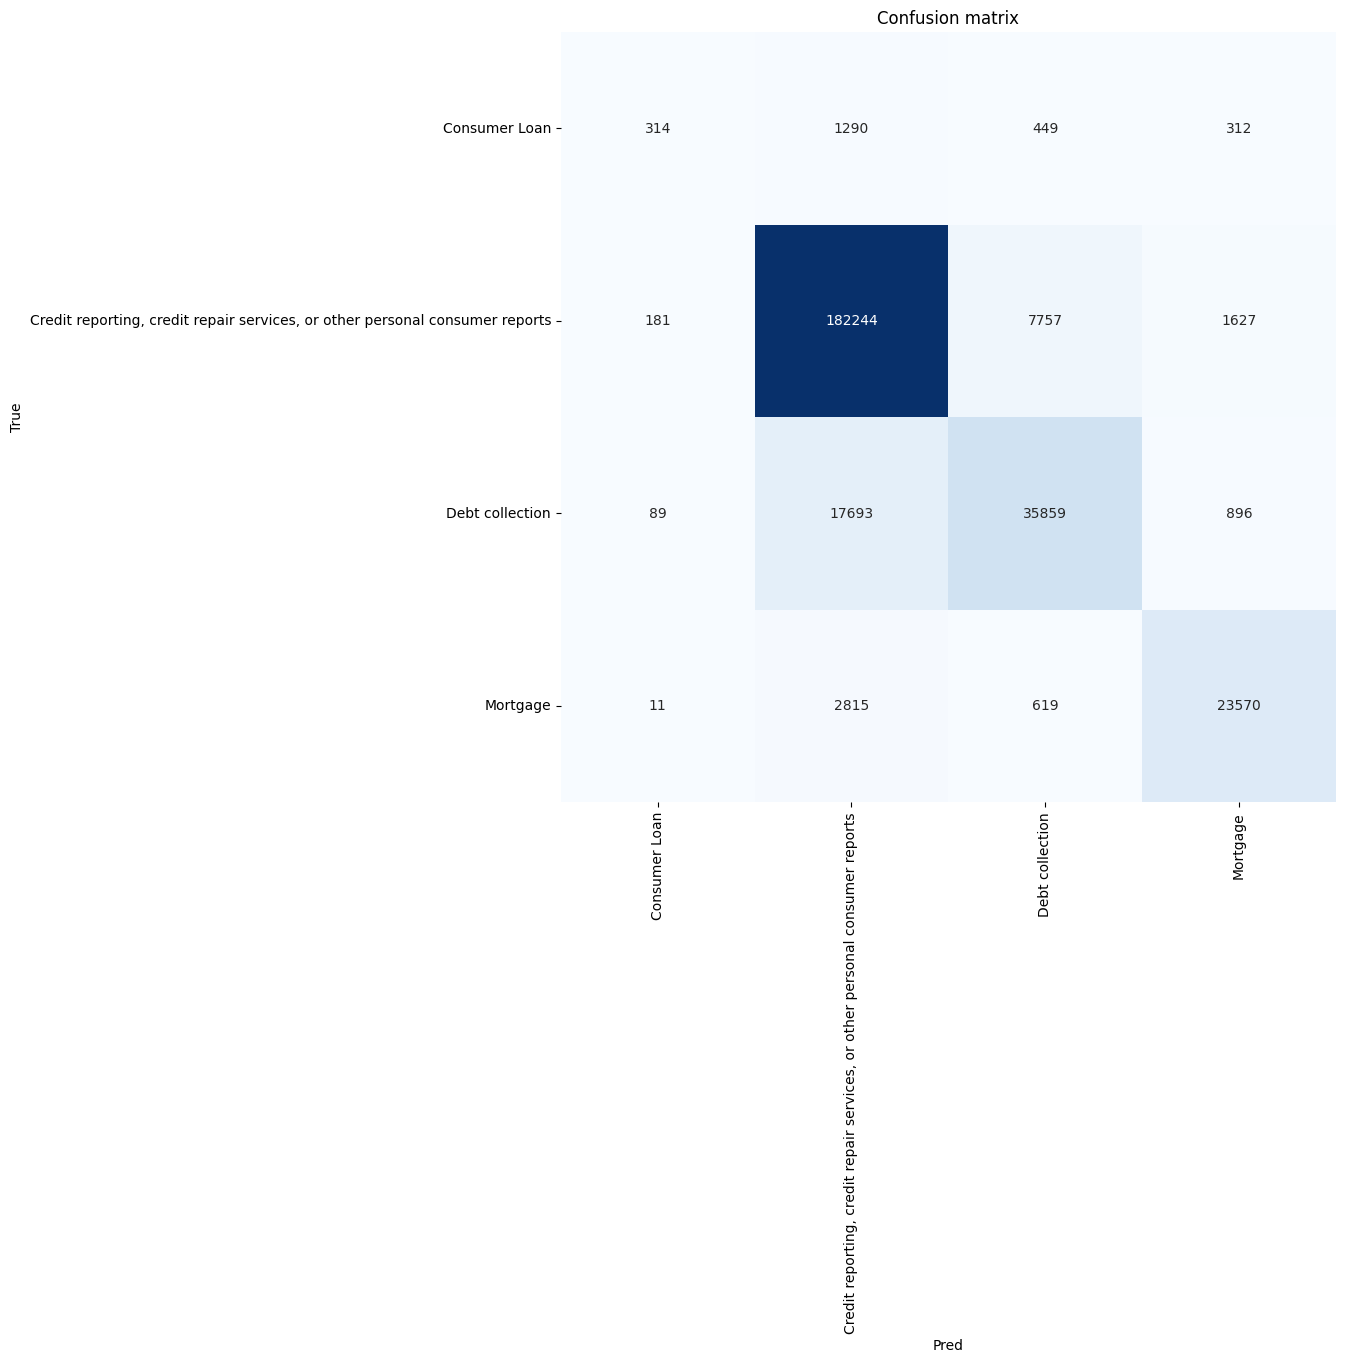

In [59]:
#confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_num, preds)
cm

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=encoder.classes_, yticklabels=encoder.classes_, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()




Niave Bayes Model to predict the product from the complaint narrative text column.

In [60]:
#nive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

nb_model  = MultinomialNB()
scores = cross_val_score(nb_model,
                            X_train_dense,
                            y_train_num,
                            cv=5,
                            n_jobs = -1,
                            scoring = 'accuracy')
scores.mean()


0.7926922440453998

Fit the model on the train data and predict the labels of the test data.

In [61]:
nb_model.fit(X_train_dense, y_train_num)
preds=nb_model.predict(X_test_dense)

Model evaluation

In [62]:
#accuracy score
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_num, preds))



0.7940310308059451


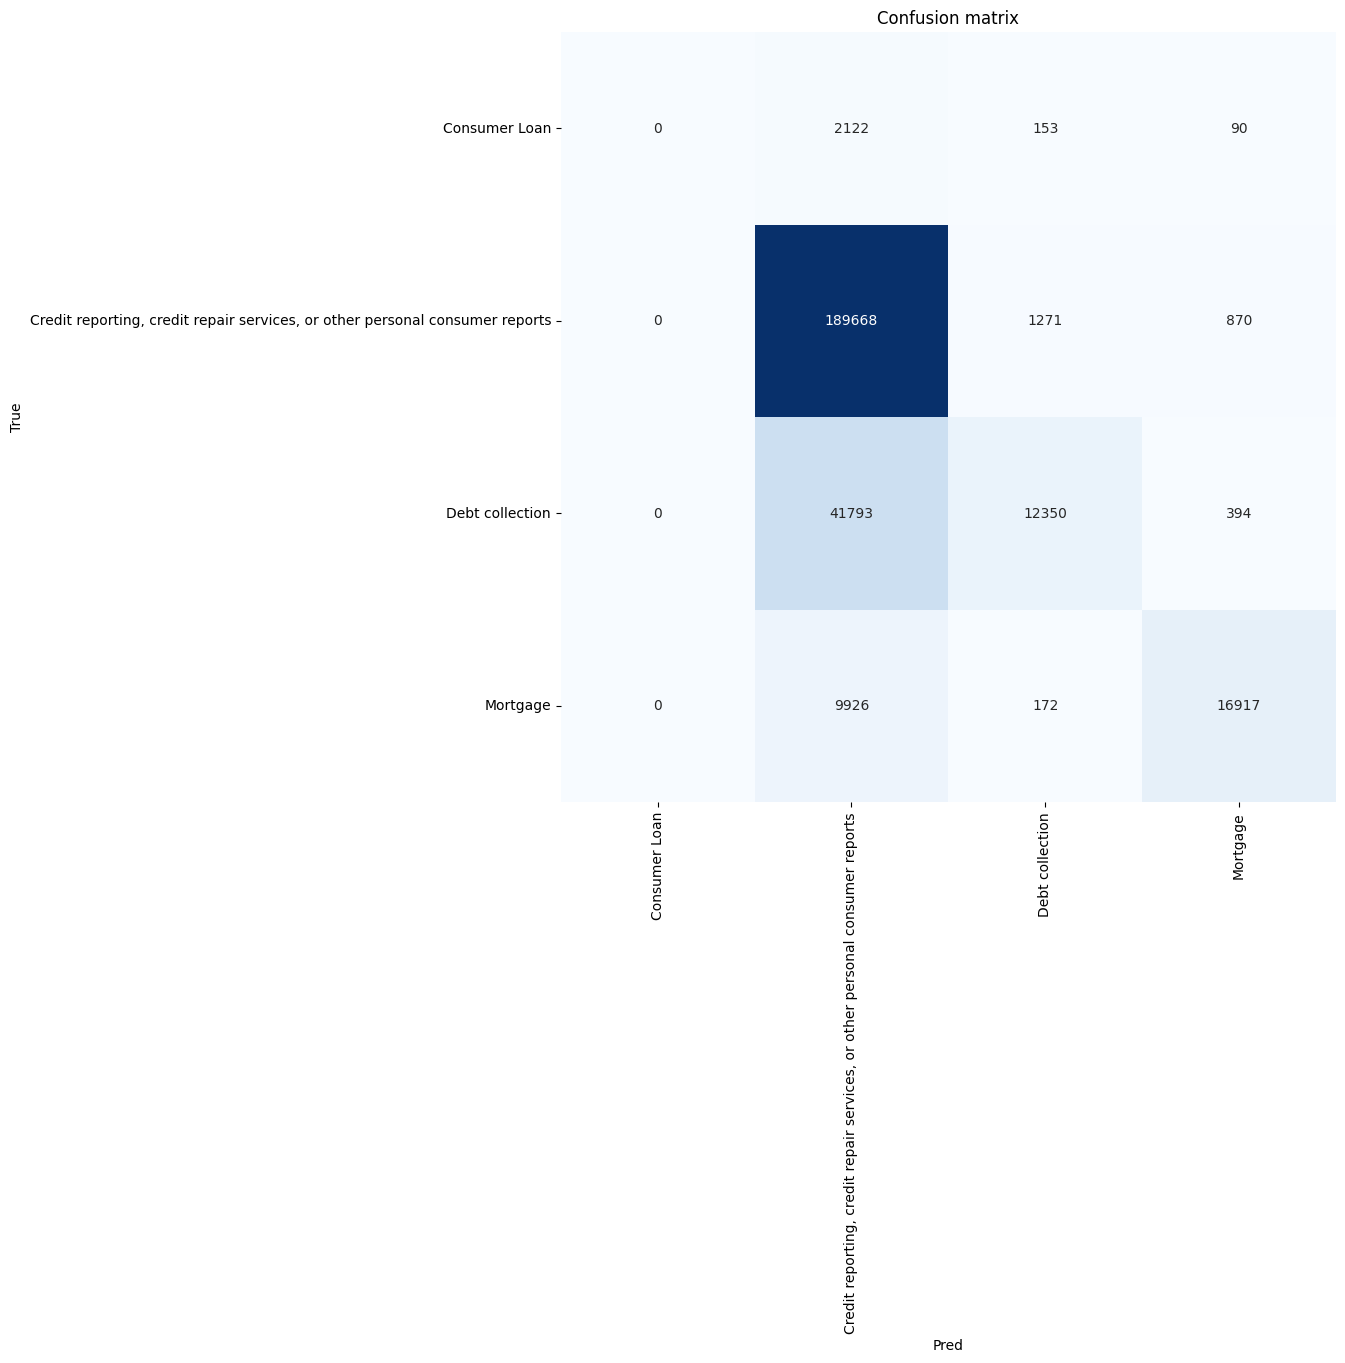

In [63]:
#confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_num, preds)
cm

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=encoder.classes_, yticklabels=encoder.classes_, title="Confusion matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

